**GRASP-AND-LIFT EEG Detection Project**

This project aims to compare different machine learning models in terms of viability for detecting events from EEG signals.

In [244]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mne

**Introduction**

Training data consists of EEG recordings of subjects performing grasp-and-lift trials.

There are 12 subjects in total, 10 series of trials for each subject.

Each series recorded 32 EEG channels with sampling rate 500Hz.

Training data contains id columns, representing the subject, series, and time at which data point was recorded.


In [222]:
train_set_signals = pd.read_csv("data/train/subj1_series1_data.csv")
train_set_signals.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


The aim is to predict whether a certain event is occuring at a given point.

There are 6 events. If an event occured at a given point is represented by 1, 0 otherwise.      


In [223]:
train_set_labels = pd.read_csv("data/train/subj1_series1_events.csv")
train_set_labels.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


Setup for visualizations

In [224]:
labels = train_set_labels.columns.drop('id')
labelNames = labels.values

In [225]:
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))

In [226]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.4)
        i+=1      
    

In [227]:
def vizualize_predictions(signals, predictions, expected, labelName, limit=2000): 
    #0-31
    signalIndex = 10
    
    #Relevant only for multilabel predictions, else is always 0
    labelIndex = 0
                
    signals = pd.DataFrame(data=np.array(signals))
    axis = signals[signals.columns[signalIndex]].iloc[0:limit].plot(figsize=(20,4))  
        
    expected = pd.DataFrame(data = expected)    
    predictions = pd.DataFrame(data = np.around(predictions))
    
    expectedCropped = expected.iloc[0:limit,]
    predictionsCropped = predictions.iloc[0:limit,]
    
    highlight(expectedCropped[expectedCropped.iloc[:,labelIndex]==1].index, axis, "red")
    highlight(predictionsCropped[predictionsCropped.iloc[:,labelIndex]==1].index, axis, "black")
    
    red_patch = mpatches.Patch(color='red', label='Expected event')
    black_patch = mpatches.Patch(color='black', label='Predicted event')
    plt.legend(handles=[red_patch, black_patch])

    plt.title(labelName)
    plt.show()

Helper methods for loading data

Features are standartized by removing the mean and scaling to unit variance

Further preprocessing can be done in *prepare_signals* function

In [228]:
import math
from sklearn.preprocessing import StandardScaler

def load_train_data(subject, series):
    train_set_signals = pd.read_csv(f"data/train/subj{subject}_series{series}_data.csv")
    train_set_labels = pd.read_csv(f"data/train/subj{subject}_series{series}_events.csv")
    return train_set_signals, train_set_labels

def prepare_labels(data):    
    return data.drop("id", axis=1)
    
def prepare_signals(data):
    data = data.drop("id", axis=1)
    columns = data.columns      
    
    #Preprocessing    
    scaler = StandardScaler() 
    data =np.asarray(data.astype(float))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=columns) 
    
    return data
    
def load_train_data_prepared(subject, series):    
    signals, labels = load_train_data(subject,series)    
    return prepare_signals(signals), prepare_labels(labels)   


Helper for printing success rates for given predictions and expected values

In [229]:
def rd(x):
        return round(x)

def printSucc(predictions, expected, dataLabel):
    #success counters
    succ = 0
    onesTotal = 0
    onesSucc = 0
    
    #Compute successes in data
    for i in range(len(predictions)):    
        if(round(predictions[i][0]) == expected[i]):
            succ+=1

        if 1 == expected[i]:
            onesTotal += 1           
            if(round(predictions[i][0]) == 1):
                onesSucc +=1           

    print(dataLabel, "success", "---","TOTAL =", "{:0.4f}".format(succ/len(predictions)), "|||","EVENT =","{:0.4f}".format(onesSucc/onesTotal) ,"(", onesSucc, "/",onesTotal, ")")    
    
    return succ/len(predictions), onesSucc/onesTotal

**RECURRENT NEURAL NETWORK**

RNN with LSTM, dropout and activation layers

* Adam optimizer
* Binary crossentropy loss 
* Sigmoid activation layer

Transform 2D dataset to 3D for LSTM layer - add floating window of *look_back* length

In [230]:
def create_sequences(dataset,labels, look_back=1):
    dataX = []
    dataY = labels[look_back//2:-look_back//2]
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), ])
    return np.array(dataX), np.array(dataY)


Tests given rnn model on predicting label or more labels from testing data.

Provides visualisations and success rates.





In [231]:
#data are downsampled, each 15th data point is taken
DOWNSAMPLING = 15
LOOK_BACK = 36
BATCH_SIZE = 512

#Iterations on stateful model, epochs on non-stateful
EPOCHS = 30
ITERATIONS = 1
STATEFUL = False
SHUFFLE = not STATEFUL
VERBOSE = 0    

In [242]:
def evaluate_rnn(subject, model, label, draw):
    #Last (8th) series is used as testing data
    test_signals, test_labels = load_train_data_prepared(subject=subject,series=8)
    
    #Creating sequences for lstm layer
    X_test_signals, X_test_labels = create_sequences(
        test_signals.values[::DOWNSAMPLING],
        test_labels.values[::DOWNSAMPLING],
        look_back=LOOK_BACK
    )
    #Selecting only desired labels
    X_test_labels = X_test_labels[:,label] 

    #Last few data points that do not fit batch size are omitted 
    croppedSize = math.floor(len(X_test_signals)/BATCH_SIZE)*BATCH_SIZE    

    #Prediction for testing data
    predictions = model.predict(X_test_signals[0:croppedSize], batch_size=BATCH_SIZE)
    expected = X_test_labels[0:croppedSize]
    
    #Selecting only desired labels   
    labelsPredicted = len(predictions[0])
    if(labelsPredicted == 1):
        predictions = predictions[:,0:1]
    else: #6 labels predicted    
        predictions = predictions[:,label] 
    
            
    #Success rate printing    
    totalPercent, onesPercent = printSucc(predictions,expected, dataLabel="Testing")
    
    #Vizualization
    if(draw):
        vizualize_predictions(
            test_signals.values[::DOWNSAMPLING][LOOK_BACK//2:croppedSize+LOOK_BACK//2:],
            predictions,
            expected,
            labelName = labelNames[label],  
            limit = 1000
        )
    
    return totalPercent, onesPercent    

Training of a single model for a single or more subjects.

Uses series 1-7 (leaves series 8 for testing)

In [233]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout

def train_rnn(subjects, labelToTrain, model, callbacks): 
    #For specified subjects
    for subject in subjects:
        #For series 1-7 
        for j in range(1,8):    # TODO change
            signals, labels = load_train_data_prepared(subject = subject,series = j) 
            #Create sequences
            X_train_signals, X_train_labels = create_sequences(
                signals.iloc[::DOWNSAMPLING].values,
                labels.iloc[::DOWNSAMPLING].values,
                look_back=LOOK_BACK       
            )        

            X_train_labels = X_train_labels[:,labelToTrain]
            croppedSize = math.floor(len(X_train_signals)/BATCH_SIZE)*BATCH_SIZE        
            #Train model on relevant label (calling fit repeatedly in keras doesnt reset the model)
            model.fit(
                X_train_signals[0:croppedSize],
                X_train_labels[0:croppedSize],
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=SHUFFLE,
                verbose=VERBOSE,
                callbacks=callbacks
            )            
            
            model.reset_states()
    
    
    print("FITTING DONE")
    return model

Training of model for given subjects and evaluating it.

Evaluating each label success rate separarely and averaging them. Random behaviour has 50% success rate.

For given subject, we use first 7 series as training data and 8'th series as test data. 

In [234]:
def rnn_validation(model, trainSeparateLabels, callbacks, draw=False, subjectToEvaluateOn = 1, label=0):
    print(labelNames[label],"label model evaluation")
    
    total, ones = evaluate_rnn(subjectToEvaluateOn, model, label, draw = draw)

    print("SUMMARY")
    print("TOTAL :", total)
    print("EVENTS :", ones)

RNN configuration

In [235]:
from keras.callbacks import EarlyStopping

callbacks=[EarlyStopping(monitor="accuracy", verbose=0, patience=10, restore_best_weights=True)]

Basic model, training all labels at once for single subject

Stacked model, training all labels separately for single subject

In [236]:
LABEL = 0

In [237]:
model = Sequential()
model.add(LSTM(50,batch_input_shape=(BATCH_SIZE,LOOK_BACK,32), return_sequences=True, stateful=STATEFUL, dropout=0.5, activation="softsign")) 
model.add(LSTM(50, return_sequences=False, stateful=STATEFUL, dropout=0.5, activation="softsign"))     
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [238]:
    #Separate models for training all labels separately
model = train_rnn(  
    subjects = [1],
    labelToTrain=LABEL,
    model = model,
    callbacks=callbacks
    )

FITTING DONE


HandStart label model evaluation
16/16 [==============================] - 0s 23ms/step
Testing success --- TOTAL = 0.9504 ||| EVENT = 0.4706 ( 160 / 340 )


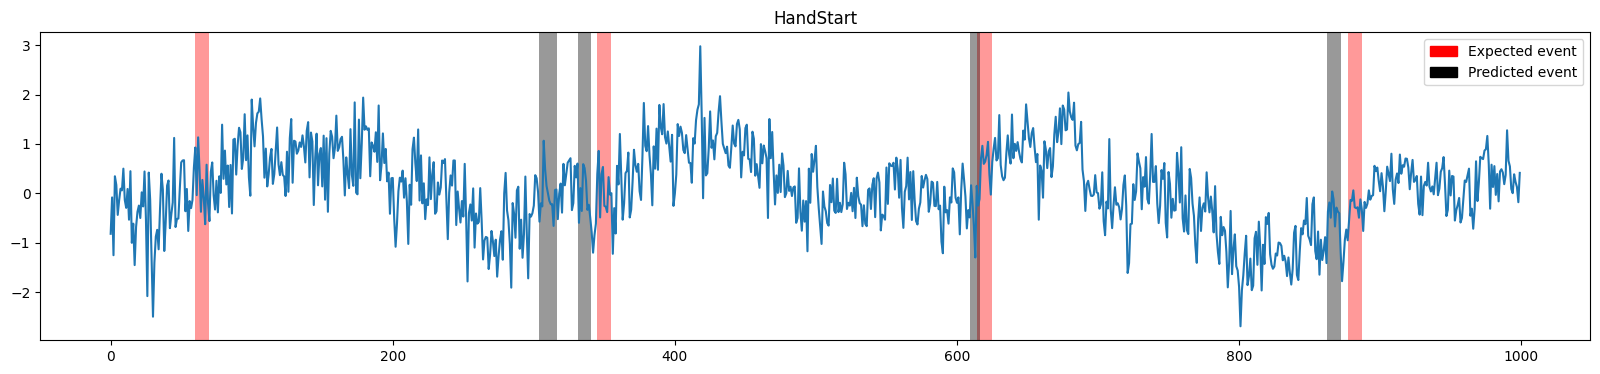

SUMMARY
TOTAL : 0.950439453125
EVENTS : 0.47058823529411764


In [243]:
rnn_validation(
               model = model,
               trainSeparateLabels=True,
               draw=True,
               subjectToEvaluateOn=10,
               callbacks=callbacks,
               label=LABEL
              )